In [216]:
import pandas as pd
import numpy as np
import math
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn import preprocessing
pd.set_option('display.max_columns', 200)

In [217]:
account = pd.read_csv("./data/account.csv", na_values= ['?', 'NA', ''],sep= ';')
card_test = pd.read_csv("./data/card_test.csv",na_values= ['?', 'NA', ''],sep=  ';')
card_train = pd.read_csv("./data/card_train.csv",na_values= ['?', 'NA', ''],sep=  ';')
client = pd.read_csv("./data/client.csv",na_values= ['?', 'NA', ''],sep=  ';')
disposition = pd.read_csv("./data/disp.csv",na_values= ['?', 'NA', ''],sep=  ';')
district = pd.read_csv("./data/district.csv",na_values= ['?', 'NA', ''],sep= ';')
loan_test = pd.read_csv("./data/loan_test.csv", na_values= ['?', 'NA', ''],sep= ';')
loan_train = pd.read_csv("./data/loan_train.csv",na_values= ['?', 'NA', ''],sep=  ';')
trans_test = pd.read_csv("./data/trans_test.csv",na_values= ['?', 'NA', ''],sep=  ';')
trans_train = pd.read_csv("./data/trans_train.csv",na_values= ['?', 'NA', ''],sep=  ';')

## Useful functions

In [218]:
def column_density_plot(df, col):
    sb.kdeplot(df[col], shade=True)
    plt.show()

In [219]:
def get_correlation(df):
   
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
   
    plt.subplots(figsize=(10,8))
  
    cmap = sb.diverging_palette(220, 10, as_cmap=True)

    ax = sb.heatmap(corr, mask=mask, cmap=cmap, center=0,square=True, linewidths=.1, cbar_kws={"shrink": .5})
    
    y_lim = ax.get_ylim();
    ax.set_ylim(np.ceil(y_lim[0]), np.floor(y_lim[1]))

    plt.show()

Let's start by cleaning the individual tables, to have them ready to merge!

## Transaction Table

In [220]:
print(trans_train.info())
print(trans_train["type"].value_counts())
print("\n\tOperation:")
print(trans_train["operation"].value_counts())
print("\n\tK_symbol:")
print(trans_train["k_symbol"].value_counts())
print(trans_train["k_symbol"].isnull().sum())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396685 entries, 0 to 396684
Data columns (total 10 columns):
trans_id      396685 non-null int64
account_id    396685 non-null int64
date          396685 non-null int64
type          396685 non-null object
operation     325924 non-null object
amount        396685 non-null float64
balance       396685 non-null float64
k_symbol      211441 non-null object
bank          97242 non-null object
account       102229 non-null float64
dtypes: float64(3), int64(3), object(4)
memory usage: 30.3+ MB
None
withdrawal            232093
credit                159468
withdrawal in cash      5124
Name: type, dtype: int64

	Operation:
withdrawal in cash              165270
remittance to another bank       70737
credit in cash                   62202
collection from another bank     26505
credit card withdrawal            1210
Name: operation, dtype: int64

	K_symbol:
interest credited                        70761
payment for statement                    58

In the transaction table, we observed several details that helped us clean this table:
- The 'bank' and 'account' collumns only have information of the sending accounts, which aren't relevant to our problem, so they can be dropped
- The 'k_symbol' has a lot of null values and most of them are "interested credit" that can be put on the operation row, so this collumn can be dropped and merged with operation
- 'Withdrawal in cash' in an option both in operation and type, which doesn't make sense, so we can change all occurences of 'Withdrawal in cash' to simply 'Withdrawal' in the 'type' collumn
- The values in the 'ammount' collumn should be negative when 'type' is 'Withdrawal'

In [221]:



def clean_transaction(filename):
    trans = pd.read_csv(filename,na_values= ['?', 'NA', ''],sep=  ';')
 #   trans.loc[trans["operation"].isna(),"operation"] = trans.loc[trans["operation"].isna(),"k_symbol"]
    trans.loc[trans["type"]=="withdrawal in cash","type"] = "withdrawal"
    trans.loc[trans["type"]=="withdrawal","amount"] *=-1 
 #   trans = trans.drop(['k_symbol'], axis=1)
    trans = trans.drop(['bank', 'account'], axis=1)
 #   trans["date"] = pd.to_datetime(trans['date'], format='%y%m%d')

    #group balances of the same account and get avg, min and max values of balance
    grouped_balance = trans.sort_values(by=['account_id', 'date'],
                                            ascending=[True, False]).groupby(['account_id']).agg({'balance': ['mean', 'max', 'min','std']}).reset_index()
    grouped_balance.columns = ['account_id', 'balance_mean', 'balance_max', 'balance_min', 'balance_std']
    grouped_balance['reached_negative_balance'] = grouped_balance['balance_min']
    grouped_balance.loc[grouped_balance["balance_min"] >= 0, "reached_negative_balance"] = 0
    grouped_balance.loc[grouped_balance["balance_min"] < 0, "reached_negative_balance"] = 1

   # 
    aux_types = trans.sort_values(by=['account_id', 'date'],ascending=[True, False]).groupby(['account_id', 'type']).agg({'amount': ['mean', 'count', 'max', 'min']}).reset_index()
    aux_types.columns = ['account_id', 'type', 'type_mean', 'type_count','type_max', 'type_min']

    grouped_credits = aux_types[aux_types['type'] == 'credit']
    grouped_credits.columns = ['account_id', 'type', 'credit_mean', 'credit_count','credit_max', 'credit_min']
    grouped_credits=grouped_credits.drop(['type'], axis=1)
    
    grouped_withdrawals = aux_types[aux_types['type'] == 'withdrawal']
    grouped_withdrawals.columns = ['account_id', 'type', 'withdrawal_mean', 'withdrawal_count', 'withdrawal_max', 'withdrawal_min']
    grouped_withdrawals=grouped_withdrawals.drop(['type'], axis=1)
  

    group_k_symbol = trans.groupby(['account_id', 'k_symbol']).agg({'amount': ['mean', 'sum', 'count']}).reset_index()
    group_k_symbol.columns = ['account_id', 'k_symbol', 'amount_mean','amount_sum', 'amount_count']

      # extract households stats
    households = group_k_symbol[group_k_symbol['k_symbol'] == 'household']
    households.columns = ['account_id', 'k_symbol', 'household_mean', 'household_sum', 'household_count']
    households = households.drop(['k_symbol'], axis=1)
    
    # extract pensions stats
    pensions = group_k_symbol[group_k_symbol['k_symbol'] == 'old-age pension']
    pensions.columns = ['account_id', 'k_symbol', 'pension_mean', 'pension_sum', 'pension_count']
    pensions = pensions.drop(['k_symbol'], axis=1)
    
    # extract sanction payment stats
    sanctions = group_k_symbol[group_k_symbol['k_symbol'] == 'sanction interest if negative balance']
    sanctions.columns = ['account_id', 'k_symbol', 'sanctions_mean', 'sanctions_sum',
                        'sanctions_count']
    sanctions = sanctions.drop(['k_symbol'], axis=1)

    # extract payments for statement stats
    payment_st = group_k_symbol[group_k_symbol['k_symbol'] == 'payment for statement']
    payment_st.columns = ['account_id', 'k_symbol', 'payment_statement_mean', 'payment_statement_sum',
                        'payment_statement_count']
    payment_st = payment_st.drop(['k_symbol'], axis=1)
    
    # extract insurance payment stats
    insurances = group_k_symbol[group_k_symbol['k_symbol'] == 'insurrance payment']
    insurances.columns = ['account_id', 'k_symbol', 'insurances_mean', 'insurances_sum',
                        'insurances_count']
    insurances = insurances.drop(['k_symbol'], axis=1)

    processed_trans = grouped_balance.merge(grouped_credits, on='account_id', how='left')\
                     .merge(grouped_withdrawals, on='account_id', how='left')\
                     .merge(households, on='account_id', how='left')\
                     .merge(pensions, on='account_id', how='left')\
                     .merge(payment_st, on='account_id', how='left')\
                     .merge(insurances, on='account_id', how='left')\
                     .merge(sanctions, on='account_id', how='left')
    processed_trans=processed_trans.fillna(0)
  #  processed_trans.to_csv("pt.csv")
   
    

    return processed_trans


trans_train=clean_transaction("./data/trans_train.csv")
trans_test=clean_transaction("./data/trans_test.csv")


In [222]:
def clean_loan(filename):
    loan = pd.read_csv(filename,na_values= ['?', 'NA', ''],sep=  ';')
    #loan["date"] = pd.to_datetime(loan['date'], format='%y%m%d')
    return loan

loan_train=clean_loan("./data/loan_train.csv")
loan_test=clean_loan("./data/loan_test.csv")


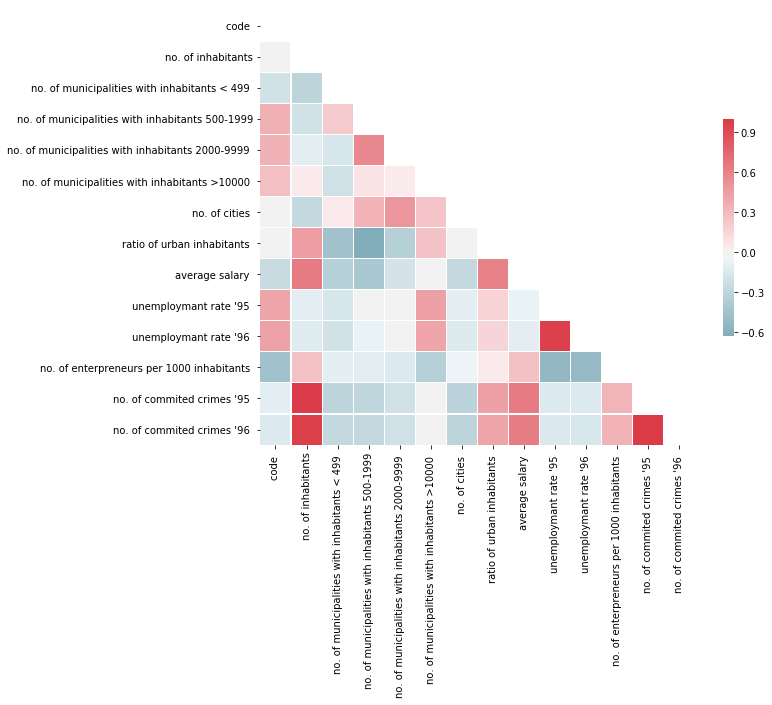

In [231]:
def clean_district():
    district["unemploymant rate '95 "]=pd.to_numeric(district["unemploymant rate '95 "], errors='coerce')
    district["unemploymant rate '95 "]=district["unemploymant rate '95 "].fillna(district["unemploymant rate '95 "].mean())

    district["no. of commited crimes '95 "]=pd.to_numeric(district["no. of commited crimes '95 "], errors='coerce')
    district["no. of commited crimes '95 "]=district["no. of commited crimes '95 "].fillna(district["no. of commited crimes '95 "].mean())
    get_correlation(district)
    return district
 
clean_district=clean_district()

In [224]:
def clean_card(filename):
    card = pd.read_csv(filename,na_values= ['?', 'NA', ''],sep=  ';')
    #card["issued"] = pd.to_datetime(card['issued'], format='%y%m%d')
    group_k_symbol = card.groupby([ 'card_id']).agg({'type': ['count']}).reset_index()
    group_k_symbol.columns = ['card_id', 'count']
    print(group_k_symbol)
    return card
card_train=clean_card("./data/card_train.csv")
card_test=clean_card("./data/card_test.csv")

card_id  count
0          3      1
1          5      1
2         10      1
3         12      1
4         13      1
5         14      1
6         15      1
7         18      1
8         24      1
9         37      1
10        38      1
11        40      1
12        44      1
13        57      1
14        70      1
15        84      1
16        85      1
17        87      1
18        88      1
19        92      1
20        97      1
21        98      1
22        99      1
23       103      1
24       104      1
25       106      1
26       107      1
27       113      1
28       117      1
29       118      1
..       ...    ...
147      722      1
148      725      1
149      731      1
150      732      1
151      736      1
152      737      1
153      741      1
154      747      1
155      759      1
156      763      1
157      764      1
158      766      1
159      771      1
160      772      1
161      776      1
162      778      1
163      779      1
164      783      1
165  

In [225]:
def build_client_disp_card(card):
   disp_card = disposition.merge(card,on='disp_id', how='left',suffixes = ('', '_card'))
   #.merge(card,on='disp_id', how='left')
   num_holders=disposition.groupby([ 'account_id']).agg({'type': ['count']}).reset_index()
   num_holders.columns = ['account_id', 'num_holders']


   num_cards=disp_card.groupby([ 'account_id']).agg({'card_id': ['count']}).reset_index()
   num_cards.columns = ['account_id', 'num_cards']
   print(num_cards['num_cards'].value_counts())#->there's only ever one or zero cards per account
   card_type=disp_card.filter(['account_id','type_card'])
   card_type=card_type.drop_duplicates(['account_id'])

   #manually encode card_type 
   card_type['type_card'] = card_type['type_card'].replace(['junior'],1)
   card_type['type_card'] = card_type['type_card'].replace(['classic'],2)
   card_type['type_card'] = card_type['type_card'].replace(['gold'],3)
   card_type=card_type.fillna(0)


   #merge the 3 new columns
   account_aux_info=num_holders.merge(num_cards,on='account_id',how='left').merge(card_type,on='account_id',how='left')
  
   return account_aux_info




In [226]:
def fix_birthday(x):
    s = str(x)
    if(int(str(x)[2:4])>12):
        partial=str(int(s[2:4])-50)
        if(len(partial)==1): 
            partial="0"+partial  
        res=s[0:2]+partial+s[4:]
    else:
        return x
    return int(res)

def fix_date(x):
    if x.year > 2000:
        year = x.year - 100
    else:
        year = x.year
    return datetime.date(year,x.month,x.day)


def clean_client():
    client['gender'] = client['birth_number'].apply(lambda x: 'M' if (int(str(x)[2:4])<=12) else 'F')
    client["birth_number"] = client["birth_number"].apply(fix_birthday)
    #client["birth_number"] = pd.to_datetime(client['birth_number'], format='%y%m%d')
    #client["birth_number"] = client["birth_number"].apply(fix_date)

clean_client()





In [227]:
def build_dataset(trans, loans, cards):
    final_dataset=loans.merge(account, on='account_id', how='inner',suffixes=('_loan','_account'))
    final_dataset = final_dataset.merge(district,  left_on='district_id', right_on="code ", how='inner')
    final_dataset = final_dataset.drop(columns=["code "])
    final_dataset = final_dataset.rename(
        columns={'name ': 'account_district_name',
                'region': 'account_district_region', 'no. of inhabitants': 'account_district_no. of inhabitants',
                'no. of municipalities with inhabitants < 499 ': 'account_district_no. of municipalities with inhabitants < 499',
                'no. of municipalities with inhabitants 500-1999': 'account_district_no. of municipalities with inhabitants 500-1999',
                'no. of municipalities with inhabitants 2000-9999 ': 'account_district_no. of municipalities with inhabitants 2000-9999',
                'no. of municipalities with inhabitants >10000 ': 'account_district_no. of municipalities with inhabitants >10000',
                'no. of cities ': 'account_district_no. of cities', 'ratio of urban inhabitants ': 'account_district_ratio of urban inhabitants',
                'average salary ': 'account_district_average salary', 'unemploymant rate \'95 ': 'account_district_unemploymant rate \'95',
                'unemploymant rate \'96 ': 'account_district_unemploymant rate \'96',
                'no. of enterpreneurs per 1000 inhabitants ': 'account_district_no. of enterpreneurs per 1000 inhabitants',
                'no. of commited crimes \'95 ': 'account_district_no. of commited crimes \'95',
                'no. of commited crimes \'96 ': 'account_district_no. of commited crimes \'96'})
    client_data = client.merge(disposition, on='client_id', how='inner')
    client_data = client_data.merge(district,  left_on='district_id', right_on="code ", how='inner')
    client_data = client_data.rename(
        columns={'code ': 'client_district_id', 'name ': 'client_district_name', 
        'region': 'client_district_region', 'no. of inhabitants': 'client_district_no. of inhabitants', 
        'no. of municipalities with inhabitants < 499 ': 'client_district_no. of municipalities with inhabitants < 499', 
        'no. of municipalities with inhabitants 500-1999': 'client_district_no. of municipalities with inhabitants 500-1999', 
        'no. of municipalities with inhabitants 2000-9999 ': 'client_district_no. of municipalities with inhabitants 2000-9999', 
        'no. of municipalities with inhabitants >10000 ': 'client_district_no. of municipalities with inhabitants >10000', 
        'no. of cities ': 'client_district_no. of cities', 'ratio of urban inhabitants ': 'client_district_ratio of urban inhabitants', 
        'average salary ': 'client_district_average salary', 'unemploymant rate \'95 ': 'client_district_unemploymant rate \'95', 
        'unemploymant rate \'96 ': 'client_district_unemploymant rate \'96', 
        'no. of enterpreneurs per 1000 inhabitants ': 'client_district_no. of enterpreneurs per 1000 inhabitants', 
        'no. of commited crimes \'95 ': 'client_district_no. of commited crimes \'95', 
        'no. of commited crimes \'96 ': 'client_district_no. of commited crimes \'96'})

    client_data = client_data[client_data['type'] == 'OWNER']
    client_data = client_data.drop(columns=["client_district_id",'type'])
    aux_info=build_client_disp_card(cards)
    final_dataset=final_dataset.merge(aux_info,on='account_id')
    final_dataset= final_dataset.merge(client_data,on =['account_id'], how='inner',suffixes=('_account','_client'))
    final_dataset = final_dataset.merge(trans, on=['account_id'], how='inner')
    final_dataset = final_dataset.drop(columns=["account_id","disp_id",'district_id_client','district_id_account', 'client_id'])
   
    return final_dataset

In [228]:
final_train=build_dataset(trans_train,loan_train,card_train)
final_test=build_dataset(trans_test,loan_test,card_test)
final_train.to_csv('final_train.csv', index = False)
final_test.to_csv('final_test.csv', index = False)
final_train.info()

0    4323
1     177
Name: num_cards, dtype: int64
0    4475
1      25
Name: num_cards, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 328 entries, 0 to 327
Data columns (total 71 columns):
loan_id                                                              328 non-null int64
date_loan                                                            328 non-null int64
amount                                                               328 non-null int64
duration                                                             328 non-null int64
payments                                                             328 non-null int64
status                                                               328 non-null int64
frequency                                                            328 non-null object
date_account                                                         328 non-null int64
account_district_name                                                328 non-null object
a

In [229]:
def encode_column(df, column):
    df_copy = df.copy()
    encoder = preprocessing.LabelEncoder()
    encoder.fit(df[column].unique())
    df_copy[column] = encoder.transform(df_copy[column])
    
    return df_copy

In [230]:
def encode_dataset(df):
    df=encode_column(df,'frequency')
    df=encode_column(df,'account_district_name')
    df=encode_column(df,'account_district_region')
    df=encode_column(df,'client_district_name')
    df=encode_column(df,'client_district_region')
    df=encode_column(df,'gender')
   
    return df

encoded_train=encode_dataset(final_train)
encoded_test=encode_dataset(final_test)
encoded_train.info()
encoded_train.to_csv('encoded_train.csv', index = False)
encoded_test.to_csv('encoded_test.csv', index = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328 entries, 0 to 327
Data columns (total 71 columns):
loan_id                                                              328 non-null int64
date_loan                                                            328 non-null int64
amount                                                               328 non-null int64
duration                                                             328 non-null int64
payments                                                             328 non-null int64
status                                                               328 non-null int64
frequency                                                            328 non-null int32
date_account                                                         328 non-null int64
account_district_name                                                328 non-null int32
account_district_region                                              328 non-null int32
account_distric